# Tutorial PAMAP2 with mcfly

This turorial is intended to talk you through the functionalities of mcfly. As an example dataset we use the publicly available PAMAP2 dataset. It contains time series data from movement sensors worn by nine individuals. The data is labelled with the activity types these individuals did and the aim is to train and evaluate a classifier.

Before you can start, please make sure you installed all the dependencies of mcfly (listed in requirements.txt) and make sure your jupyter notebook has a python3 kernel.

## Import required Python modules

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
import numpy as np
import pandas as pd
# mcfly
from mcfly import tutorial_pamap2, modelgen, find_architecture
# Keras module is use for the deep learning
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
# We can set some backend options to avoid NaNs
from keras import backend as K

Using Theano backend.


## Download data and pre-proces data

We have created a function for you to fetch and pre-proces the data. Please specify the 'directory_to_extract_to' in the code below and then execute the cell. The second time you run this cell it function will recognized that you previously fetched and processed the data and it will skipp the processing. The output of the function is outputpath which indicates where the data was previously stored.

In [2]:
# Specify in which directory you want to store the data:
directory_to_extract_to = "/media/windows-share"
# Specifcy which columns to use. You can leave this as it is
columns_to_use = ['hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z',
                 'ankle_acc_16g_x', 'ankle_acc_16g_y', 'ankle_acc_16g_z',
                 'chest_acc_16g_x', 'chest_acc_16g_y', 'chest_acc_16g_z']
outputpath = tutorial_pamap2.fetch_and_preprocess(directory_to_extract_to,columns_to_use)

Data previously downloaded and stored in /media/windows-share/PAMAP2
Data previously pre-processed and np-files saved to /media/windows-share/PAMAP2/PAMAP2_Dataset/slidingwindow512cleaned/


## Load the pre-processed data

Load the preprocessed data as stored in Numpy-files. Please note that the data has already been split up in a training (training), validation (val), and test subsets.

In [3]:
X_train, y_train_binary, X_val, y_val_binary, X_test, y_test_binary = tutorial_pamap2.load_data(outputpath)

## Generate models

First step is to create a model architecture. As we do not know what architecture is best for our data we will create a set of models to investigate which architecture is most suitable for our data and classification task. You will need to specificy how many models you want to create with argument 'number_of_models', the type of model which can been 'CNN' or 'DeepConvLSTM', and maximum number of layers per modeltype. See for a full overview of the optional arguments the function documentation of modelgen.generate_models

In [4]:
num_classes = y_train_binary.shape[1]
models = modelgen.generate_models(X_train.shape,
                                  number_of_classes=num_classes,
                                  number_of_models = 3, #10,
                                  model_type = 'CNN',
                                  cnn_max_layers=4,
                                  deepconvlstm_max_conv_layers=3,
                                  deepconvlstm_max_lstm_layers=2)

In [5]:
# Inspect models:
models_to_print = [0,2] #range(len(models))
for i, item in enumerate(models):
    if i in models_to_print:
        model, params, model_types = item
        print("-------------------------------------------------------------------------------------------------------")
        print("Model " + str(i))
        print(" ")
        print("Hyperparameters:")
        print(params)
        print(" ")
        print("Model description:")
        model.summary()
        print(" ")
        print("Model type:")
        print(model_types)
        print(" ")

-------------------------------------------------------------------------------------------------------
Model 0
 
Hyperparameters:
{'learning_rate': 0.0010042381170177407, 'fc_hidden_nodes': 912, 'regularization_rate': 0.0027333410942024477, 'filters': array([62, 16, 24])}
 
Model description:
____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
batchnormalization_1 (BatchNormaliz(None, 512, 9)      18          batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)    (None, 512, 62)     1736        batchnormalization_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_2 (BatchNormaliz(None, 512, 62)     124         convolution1d_1[0][0]           

## Compare models
Now that the model architectures have been generated it is time to compare the models by training them in a subset of the training data and evaluating the models in the validation subset. This will help us to choose the best candidate model. Performance results are stored in a json file.

In [6]:
# Define directory where the results, e.g. json file, will be stored
resultpath = directory_to_extract_to + '/PAMAP2/PAMAP2_Dataset/results/' 
if not os.path.exists(resultpath):
        os.makedirs(resultpath)

In [7]:
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                           X_val, y_val_binary,
                                                                           models,nr_epochs=5,
                                                                           subset_size=300,
                                                                           verbose=True,
                                                                           outputfile=resultpath+\
                                                                                  'modelcomparison.json')

Training model 0 CNN
Train on 300 samples, validate on 2007 samples
Epoch 1/5
300/300 [==============================] - 20s - loss: 4.5212 - acc: 0.6033 - val_loss: 1.5281 - val_acc: 0.5376
Epoch 2/5
300/300 [==============================] - 20s - loss: 4.0966 - acc: 0.8233 - val_loss: 1.0591 - val_acc: 0.7544
Epoch 3/5
300/300 [==============================] - 19s - loss: 3.5665 - acc: 0.8833 - val_loss: 1.0693 - val_acc: 0.7145
Epoch 4/5
300/300 [==============================] - 23s - loss: 3.0965 - acc: 0.8833 - val_loss: 0.9979 - val_acc: 0.7454
Epoch 5/5
300/300 [==============================] - 21s - loss: 2.5822 - acc: 0.9567 - val_loss: 1.0222 - val_acc: 0.7668
Training model 1 CNN
Train on 300 samples, validate on 2007 samples
Epoch 1/5
300/300 [==============================] - 39s - loss: 118.6387 - acc: 0.5067 - val_loss: 9.6430 - val_acc: 0.2825
Epoch 2/5
300/300 [==============================] - 47s - loss: 172.9277 - acc: 0.6867 - val_loss: 1.5724 - val_acc: 0.5321

The histories object produced by the previous step contains the history of classifier performans with every iteration of the training process. To ease inspecting this information we developed function plotTrainingProcess, which is demonstrated in the cell below.

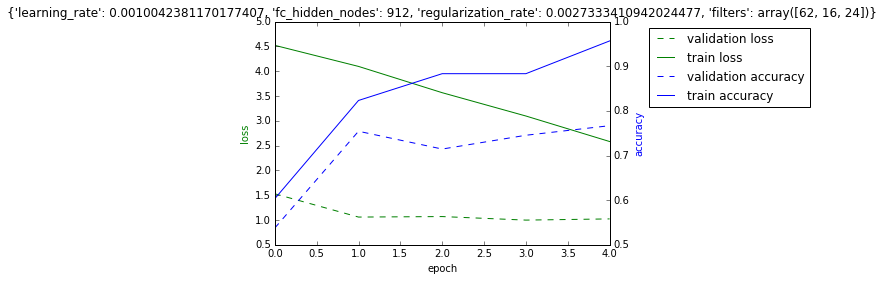

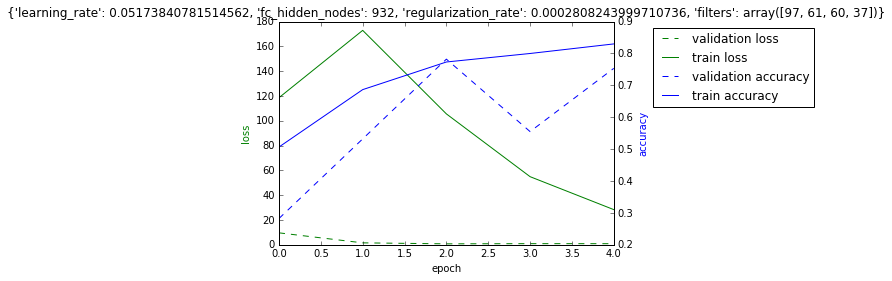

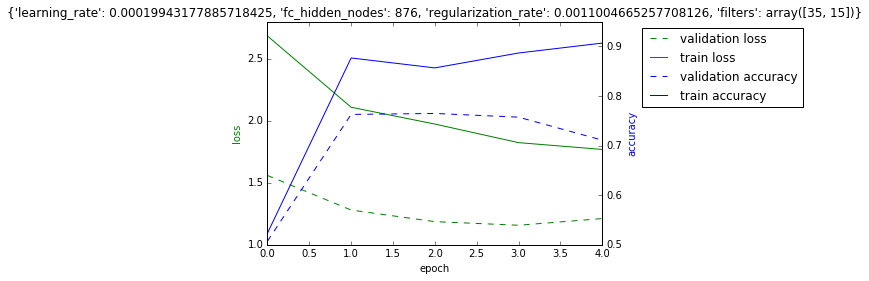

In [8]:
%matplotlib inline
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)    

Another way of comparing model performance is by putting all the information in a pandas dataframe

In [9]:
modelcomparisons = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
modelcomparisons
modelcomparisons.to_csv(resultpath +'modelcomparisons.csv')

We can also extract the same information from the json file...

###  < - - Possibly insert here demo of how to use json file that was stored

Check which model is the best

In [20]:
best_model_index = np.argmax(val_accuracies)
best_model, best_params, best_model_types = models[best_model_index]
print('Model type and parameters of the best model:')
print(best_model_types)
print(best_params)

Model type and parameters of the best model:
CNN
{'learning_rate': 0.0010042381170177407, 'fc_hidden_nodes': 912, 'regularization_rate': 0.0027333410942024477, 'filters': array([62, 16, 24])}


## Train the best model for real

Now that we have identified the best model architecture out of our random pool of models we can continue by training the model on the full training sample.

In [21]:
#We make a copy of the model, to start training from fresh
best_model_copy = modelgen.generate_CNN_model(X_train.shape, num_classes, best_params['filters'], best_params['fc_hidden_nodes'],
                       best_params['learning_rate'], best_params['regularization_rate'])
#We're going to train the model on the complete data set
nr_epochs = 10
datasize = X_train.shape[0]
history = best_model_copy.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary))

Train on 12497 samples, validate on 2007 samples
Epoch 1/10
12497/12497 [==============================] - 275s - loss: 1.6961 - acc: 0.8844 - val_loss: 0.4152 - val_acc: 0.9412
Epoch 2/10
12497/12497 [==============================] - 289s - loss: 0.7558 - acc: 0.9359 - val_loss: 0.2921 - val_acc: 0.9442
Epoch 3/10
12497/12497 [==============================] - 315s - loss: 0.6273 - acc: 0.9445 - val_loss: 0.3631 - val_acc: 0.9138
Epoch 4/10
12497/12497 [==============================] - 282s - loss: 0.5243 - acc: 0.9538 - val_loss: 0.3088 - val_acc: 0.9342
Epoch 5/10
12497/12497 [==============================] - 637s - loss: 0.4517 - acc: 0.9577 - val_loss: 0.2467 - val_acc: 0.9472
Epoch 6/10
12497/12497 [==============================] - 771s - loss: 0.4092 - acc: 0.9609 - val_loss: 0.4703 - val_acc: 0.8894
Epoch 7/10
12497/12497 [==============================] - 835s - loss: 0.3728 - acc: 0.9650 - val_loss: 0.2416 - val_acc: 0.9402
Epoch 8/10
12497/12497 [========================

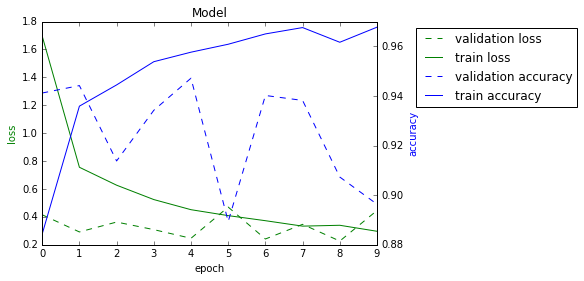

In [22]:
# Plot the training process:
find_architecture.plotTrainingProcess(history)

### <- We need function here to store the model
### <- We need function here to re-load the stored model
### <- We need function here to apply that model


## Advanced model inspection

Although beyond the scope of mcfly it may be worth highlighting that the object 'best_model' is a Keras object. This means that you can use Keras functions like .predict and .evaluate to investigate and re-use it in more detail.

In [ ]:
## Inspect model predictions
datasize = X_val.shape[0]
probs = best_model_copy.predict_proba(X_val[:datasize,:,:],batch_size=1)

In [47]:
print(np.round(probs,decimals=2))

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [48]:
## Test on Testset
score_test = best_model.evaluate(X_test, y_test_binary, verbose=False)
print('Score of best model: ' + str(score_test))

Score of best model: [1.6860336383664618, 0.42912705272255836]
